# Objective
Run algorithm one step at a time to experiment with different versions

## Imports

In [1]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
from tqdm import tqdm

from src.prop_signal import v1_4 as ps_alg
from src import plot

from src.sorters.prop_signal import PropSignal, PropUnit
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison
from src import utils

from src.recording import Recording

## Load spike times and recording

In [3]:
# Load spike times
recording_path = utils.PATH_REC_SI
SPIKE_TIMES_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/crossings.npy"
##
recording = Recording(recording_path)
SPIKE_TIMES = np.load(SPIKE_TIMES_PATH, allow_pickle=True)
SPIKE_TIMES = PropSignal.format_thresh_crossings(SPIKE_TIMES)

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


## Create candidate cohorts

In [5]:
candidate_cohorts = ps_alg.scan_reference_electrode(SPIKE_TIMES, sampling_freq=30, min_prop_spikes=900, min_ccg_ratio=0.5,
                                                    ccg_before=1.5, ccg_after=1.5, ccg_small_window=0.5, ccg_big_window=2)

Scanning reference electrodes ...


100%|██████████| 248/248 [02:37<00:00,  1.57it/s]


#### Sanity check
new scan_reference_electrode gives same results as old

In [ ]:
# %autoreload
# from src.prop_signal import v1
# candidate_cohorts1 = v1.scan_reference_electrode(SPIKE_TIMES, 1, 180, None, 0.5)
#
# for i, (one, two) in enumerate(zip(candidate_cohorts, candidate_cohorts1)):
#     if one.size <= 0: continue
#
#     ind = np.argsort(one[0, :])
#     one = one[:, ind]
#     ind = np.argsort(two[0, :])
#     two = two[:, ind]
#
#     if not np.all(np.isclose(one, two)):
#         print(i)
#         print(one[:, :4])
#         print(two[:, :4])
#         break

#### Asymmetric electrodes
Create CCG from electrodes A to B and B to A

In [ ]:
ELEC_A = 200
ELEC_B = 198

ref_spike_times = SPIKE_TIMES[ELEC_A]
tar_spike_times = SPIKE_TIMES[ELEC_B]
print(len(ref_spike_times), len(tar_spike_times))

ccg_before = 1.5
ccg_after = 1.5
sf = 30
n_tar = len(tar_spike_times)
ccgAB = np.zeros(int((ccg_before + ccg_after) * sf) + 1)
for ref in ref_spike_times:
    i_tar = np.searchsorted(tar_spike_times, ref - ccg_before)

    # Add tar spikes on left and right of index to CCG
    while 0 <= i_tar < n_tar:
        tar = tar_spike_times[i_tar]
        if tar <= ref + ccg_after:
            bin = (tar - ref + ccg_before) * sf
            ccgAB[round(bin)] += 1  # round because of floating point rounding error
        else:
            break
        i_tar += 1
hist = np.concatenate([[i] * int(ccgAB[i]) for i in range(len(ccgAB))])
print(np.argmax(ccgAB))
print(max(ccgAB))
plt.hist(hist, bins=len(ccgAB))
plt.xlim(0, len(ccgAB)-1)
plt.show()

In [ ]:
ref_spike_times = SPIKE_TIMES[ELEC_B]
tar_spike_times = SPIKE_TIMES[ELEC_A]

ccg_before = 1.5
ccg_after = 1.5
sf = 30
n_tar = len(tar_spike_times)
ccgBA = np.zeros(int((ccg_before + ccg_after) * sf) + 1)
for ref in ref_spike_times:
    i_tar = np.searchsorted(tar_spike_times, ref - ccg_before)

    # Add tar spikes on left and right of index to CCG
    while 0 <= i_tar < n_tar:
        tar = tar_spike_times[i_tar]
        if tar <= ref + ccg_after:
            bin = (tar - ref + ccg_before) * sf
            ccgBA[round(bin)] += 1  # round because of floating point rounding error
        else:
            break
        i_tar += 1
hist = np.concatenate([[i] * int(ccgBA[i]) for i in range(len(ccgBA))])
print(len(ccgBA) - 1 - np.argmax(ccgBA))
print(max(ccgBA))
plt.hist(hist, bins=len(ccgBA))
plt.xlim(0, len(ccgBA)-1)
plt.show()

#### Examine negative-latency electrode problem

In [ ]:
# Form candidate propagations (ignore negative latencies)
propagations_candidates = [np.array([]) for _ in range(len(candidate_cohorts))]
for i, cohort in enumerate(candidate_cohorts):
    if cohort.size <= 1: continue

    ind = cohort[1, :] >= 0
    thresh_cocs = max(250, 40/100 * cohort[2, 0], 50/100 * np.max(cohort[2, ind][1:]))
    cohort = cohort[:, cohort[2, :] >= thresh_cocs]
    if cohort.shape[1] > 1: propagations_candidates[i] = cohort

In [ ]:
# Pick example propagation with negative latency and matching propagation with no negative latency
for i in range(len(propagations_candidates)):
    prop = propagations_candidates[i]
    if len(prop) == 0:
        continue

    if not np.any(prop[1, :] < 0):
        continue

    print(i, prop.shape[1])
    print(prop)
    print()

#### Example of double counting

In [ ]:
propagations_candidates[73]

In [ ]:
propagations_candidates[77]

## Form propagations

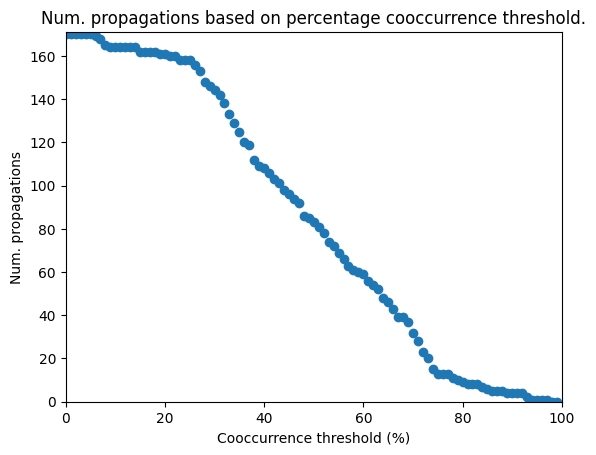

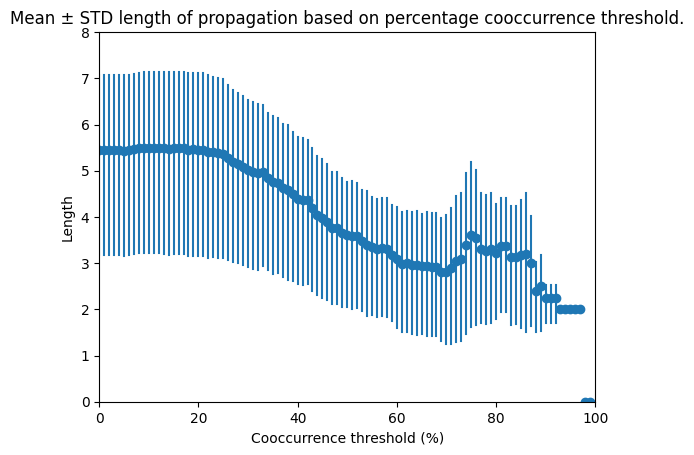

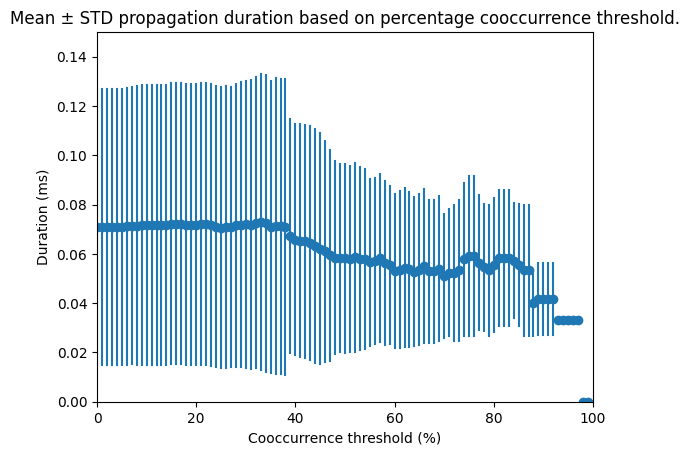

In [6]:
MIN_COCS_P_VALUES = range(0, 100)
##
nums_props = []

means_lens = []
stds_lens = []

means_durations = []
stds_durations = []
for min_cocs_p in MIN_COCS_P_VALUES:
    electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                        min_cocs_n=0, min_cocs_p=min_cocs_p,
                                                        min_cocs_2_p=50)
    propagations = ps_alg.get_propagations(electrode_cohorts, min_duration=0.001)

    prop_lens = [len(p) for p in propagations]
    nums_props.append(len(prop_lens))

    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))

        prop_durations = [PropSignal.get_sequence_duration(p) for p in propagations]
        means_durations.append(np.mean(prop_durations))
        stds_durations.append(np.std(prop_durations))
    else:
        means_lens.append(0)
        stds_lens.append(0)

        means_durations.append(0)
        stds_lens.append(0)

plt.title("Num. propagations based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Num. propagations")
plt.scatter(MIN_COCS_P_VALUES, nums_props)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, max(nums_props)+1)
plt.show()

plt.title("Mean ± STD length of propagation based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Length")
plt.scatter(MIN_COCS_P_VALUES, means_lens)
y_max = max(means_lens)+3
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_lens, stds_lens):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, 8)
plt.show()

plt.title("Mean ± STD propagation duration based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Duration (ms)")
plt.scatter(MIN_COCS_P_VALUES, means_durations)
y_max = 0.15
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_durations, stds_durations):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

In [ ]:
# # Sanity check that get_propagation gives same results as original
# %autoreload
# from src.prop_signal import v1
# props1 = v1.get_propagation(electrode_cohorts)
# for new, old in zip(propagations, props1):
#     if not np.all(new == old):
#         print(new)
#         print(old)
#         break

In [7]:
electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                    min_cocs_n=0, min_cocs_p=30,
                                                    min_cocs_2_p=50)
propagations = ps_alg.get_propagations(electrode_cohorts, 0.001)
len(propagations)

144

## Merge propagations

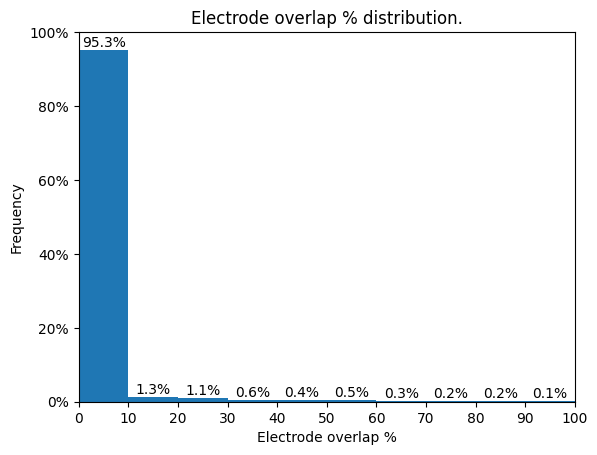

In [9]:
## Graph distribution of electrode overlap scores
scores = []
ind_a, ind_b = np.triu_indices(len(propagations), k=1)
for i_a, i_b in zip(ind_a, ind_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]
    scores.append(ps_alg.get_elec_overlap_score(propagations[i_a], propagations[i_b]) * 100)
# Create plot
plt.title("Electrode overlap % distribution.")
plt.xlabel("Electrode overlap %")
plot.plot_hist_percents(scores, bins=np.arange(0, 101, 10), labels=True)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.show()

### Development

#### Case study

In [ ]:
# Find which props to test
prop = PropUnit([propagations[29]], 0, [], recording)
prop.plot_prop(0)

In [ ]:
prop_a = propagations[26]
prop_b = propagations[29]

In [ ]:
display(prop_a)
display(prop_b)

In [ ]:
overlap_a, overlap_b = ps_alg.get_elec_overlap(prop_a, prop_b)

In [ ]:
latencies_a = prop_a.latency.values[overlap_a]
latencies_b = prop_b.latency.values[overlap_b]
pairs_a = ps_alg.get_latency_pairs(latencies_a)
pairs_b = ps_alg.get_latency_pairs(latencies_b)
seq_score = np.sum(np.abs(pairs_a - pairs_b))
seq_score

#### Score histogram

In [ ]:
## Get overlap and sequential scores
from IPython.display import display

scores = []
for a in range(len(propagations)):
    for b in range(a+1, len(propagations)):
        prop_a = propagations[a]
        prop_b = propagations[b]
        overlap = ps_alg.get_elec_overlap_score(prop_a, prop_b)
        sequential = ps_alg.get_seq_order_score(prop_a, prop_b)
        scores.append([overlap, sequential])
        
#         if sequential == 0:
#             print("-------")
#             print(a, b)
#             display(prop_a)
#             display(prop_b)
        
scores = np.array(scores)

In [ ]:
sequential_scores = scores[scores[:, 0] >= 0.5, 1]

In [ ]:
plt.title("Distribution of pair-wise sequence order scores.")
plt.hist(sequential_scores, bins=100, range=(np.min(sequential_scores), np.max(sequential_scores)))
# plt.hist(sequential_scores, bins=100, range=(0, 1))
plt.xlabel("Sequence order score")
plt.ylabel("Count")
plt.show()

In [ ]:
np.sum(sequential_scores==0)

#### Score and merge methods

In [ ]:
def get_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values
    _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True, assume_unique=True)
    return overlap_a, overlap_b

def get_elec_overlap_score(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values

    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)
    overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
    return overlap_score

In [ ]:
def get_matrix_binary(prop, overlap_ind):
    overlap_ind = set(overlap_ind)
    elecs = [prop.ID.values[e] for e in range(len(prop)) if e in overlap_ind]
    elecs = np.argsort(elecs)
    return np.clip(elecs - elecs[:, None], -1, 1)

def score_matrix_binary(prop_a, prop_b):
    # Construct sequential order matrix. Columns = reference. Rows = what reference is compared to. I.e. column rel. position - row rel. position
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)

    matrix_a = get_matrix_binary(prop_a, overlap_a)
    matrix_b = get_matrix_binary(prop_b, overlap_b)

    div = num_overlap * num_overlap - num_overlap if num_overlap > 1 else 1
    seq_order_score = np.sum(matrix_a * matrix_b) / div
    return seq_order_score

In [ ]:
def get_matrix_latency(prop, overlap_ind):
    latencies = prop.latency.values[overlap_ind]
    return latencies - latencies[:, None]

def score_matrix_latency(prop_a, prop_b):
    # Construct sequential order matrix. Columns = reference. Rows = what reference is compared to. I.e. column rel. position - row rel. position
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)

    matrix_a = get_matrix_latency(prop_a, overlap_a)
    matrix_b = get_matrix_latency(prop_b, overlap_b)

    seq_order_score = np.sum(matrix_a * matrix_b) / (np.sum(prop_a.latency) + np.sum(prop_b.latency))
    return seq_order_score

In [ ]:
def get_latency_pairs(latencies: np.ndarray):
    if latencies.size == 1:
        return latencies

    pairs = []
    for i in range(len(latencies)):
        for j in range(i+1, len(latencies)):
            pairs.append(latencies[i] - latencies[j])
    return np.asarray(pairs)

def score_sub(prop_a, prop_b):
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    if overlap_a.size == 0:
        return np.nan

    latencies_a = prop_a.latency.values[overlap_a]
    latencies_b = prop_b.latency.values[overlap_b]
    sums = np.sum(latencies_a) + np.sum(latencies_b)
    if sums < 0.0001:
        return 0
    
    pairs_a = get_latency_pairs(latencies_a)
    pairs_b = get_latency_pairs(latencies_b)
    seq_score = np.sum(np.abs(pairs_a - pairs_b))
    return seq_score / sums

In [ ]:
def get_merge_scores(merge_method):
    merge_scores = []
    ind_a, ind_b = np.triu_indices(len(propagations), k=1)
    for i_a, i_b in zip(ind_a, ind_b):
        prop_a = propagations[i_a]
        prop_b = propagations[i_b]

        overlap_score = get_elec_overlap_score(prop_a, prop_b)
        if overlap_score > 0:
            seq_score = merge_method(prop_a, prop_b)
        else:
            seq_score = np.nan

        merge_scores.append([overlap_score, seq_score])
    return np.asarray(merge_scores)

In [ ]:
def get_pdist_from_merge_scores(merge_scores, elec_overlap_min, extremum):
    pdist = merge_scores[:, 1]
    pdist[merge_scores[:, 0] < elec_overlap_min] = extremum
    return pdist

In [ ]:
def get_pdist_from_merge_scores_comb(merge_scores, elec_overlap_min, extremum):
    pdist = merge_scores[:, 1]
    pdist[merge_scores[:, 0] < elec_overlap_min] = extremum
    pdist += 1 - merge_scores[:, 0]
    return pdist

In [ ]:
def merge(pdist, seq_order_thresh,
          method, criterion):
    linkage_m = linkage(pdist, method=method)
    clusters = fcluster(linkage_m, seq_order_thresh, criterion=criterion)
    propagations_merged = {}
    for i, c in enumerate(clusters):
        if c not in propagations_merged:
            propagations_merged[c] = [propagations[i]]
        else:
            propagations_merged[c].append(propagations[i])

    propagations_merged = list(propagations_merged.values())
    return propagations_merged

#### Comparing merging methods

In [ ]:
ELEC_OVERLAP_MIN = 0.5

METHOD = "single"
CRITERION = "distance"

#### Binary matrix

In [ ]:
SEQ_ORDER_VALUES = np.linspace(0, 1.6, num=1000)

MERGE_SCORES = get_merge_scores(score_matrix_binary)
MERGE_SCORES[:, 1] = 1 - MERGE_SCORES[:, 1]
PDIST = get_pdist_from_merge_scores(MERGE_SCORES, ELEC_OVERLAP_MIN, 1.5)
##

nums_merges = []
means_lens = []
stds_lens = []
for seq_order in SEQ_ORDER_VALUES:
    prop_lens = [len(p) for p in merge(PDIST, seq_order,
                                       METHOD, CRITERION)]
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")
print(f"Elec overlap min: {ELEC_OVERLAP_MIN}")

# Create plot
# plt.title("Num. merged propagations based on percentage sequence order overlap.")
plt.title("Num. merged propagations")
# plt.xlabel("Sequence order threshold (%)")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
plt.ylim(0, max(nums_merges)+1)
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
pm_binary = merge(PDIST, 1.4, METHOD, CRITERION)
print(len(pm_binary))
pm_binary_times = get_spike_times(pm_binary)
ps_binary = PropSignal((pm_binary, pm_binary_times), recording)

#### Latency matrix

In [ ]:
SEQ_ORDER_VALUES = np.linspace(0.3, 1.5, num=1000)

MERGE_SCORES = get_merge_scores(score_matrix_latency)
MERGE_SCORES[:, 1] = 1 - MERGE_SCORES[:, 1]
PDIST = get_pdist_from_merge_scores(MERGE_SCORES, ELEC_OVERLAP_MIN, 1.4)
##

nums_merges = []
means_lens = []
stds_lens = []
for seq_order in SEQ_ORDER_VALUES:
    prop_lens = [len(p) for p in merge(PDIST, seq_order,
                                       METHOD, CRITERION)]
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")
print(f"Elec overlap min: {ELEC_OVERLAP_MIN}")

# Create plot
# plt.title("Num. merged propagations based on percentage sequence order overlap.")
plt.title("Num. merged propagations")
# plt.xlabel("Sequence order threshold (%)")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
plt.ylim(0, max(nums_merges)+1)
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
pm_latency = merge(PDIST, 1.2, METHOD, CRITERION)
print(len(pm_latency))
pm_latency_times = get_spike_times(pm_latency)
ps_latency = PropSignal((pm_latency, pm_latency_times), recording)

#### Subtraction

In [ ]:
METHOD="single"

In [ ]:
SEQ_ORDER_VALUES = np.linspace(-1, 5.2, num=1000)
ELEC_OVERLAP_MIN = 0.5

MERGE_SCORES = get_merge_scores(score_sub)
PDIST = get_pdist_from_merge_scores(MERGE_SCORES, ELEC_OVERLAP_MIN, 5)
##

nums_merges = []
means_lens = []
stds_lens = []
for seq_order in SEQ_ORDER_VALUES:
    prop_lens = [len(p) for p in merge(PDIST, seq_order,
                                       METHOD, CRITERION)]
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")
print(f"Elec overlap min: {ELEC_OVERLAP_MIN}")

# Create plot
# plt.title("Num. merged propagations based on percentage sequence order overlap.")
plt.title("Num. merged propagations")
# plt.xlabel("Sequence order threshold (%)")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
plt.ylim(0, max(nums_merges)+1)
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
pm_sub = merge(PDIST, 0.8, METHOD, CRITERION)
print(len(pm_sub))
pm_sub_times = get_spike_times(pm_sub)
ps_sub = PropSignal((pm_sub, pm_sub_times), recording)

In [ ]:
ps_sub.plot_nums_spikes(bins=40, range=(0, 40000))
plt.show()

In [ ]:
for ps in ps_sub:
    if len(ps) > 30000:
        print(len(ps))
        ps.plot()

In [ ]:
for pm in ps_sub:
    pm.plot()

In [ ]:
# ps_sub.plot_nums_spikes(show=False, bins=20)
# plt.xlim(0, 40000)
# plt.show()

##### Comparison

In [ ]:
comp_binary_latency = Comparison(ps_binary, ps_latency)
comp_binary_latency.plot_line_comps()

In [ ]:
comp_latency_sub = Comparison(ps_latency, ps_sub)
comp_latency_sub.plot_line_comps()

In [ ]:
## Plot distribution of number of propagations in each merged propagations
# propagations_merged = merge(pdist, seq_order_thresh=3.7)
propagations_merged = pm_sub
print(f"Num merged propagations: {len(propagations_merged)}")
plt.title("Distribution of the number of signals in each merged propagation.")
plt.xlabel("Number of signals")
plt.ylabel("Count")
lengths = {}
for p in propagations_merged:
    l = len(p)
    if l not in lengths:
        lengths[l] = 1
    else:
        lengths[l] += 1
plt.bar(lengths.keys(), lengths.values())
plt.xticks(list(lengths.keys()))
for l, c in lengths.items():
    plt.text(l, c, str(c), ha="center", va="bottom")
plt.show()

In [ ]:
# for i in range(len(propagations_merged)):
#     PropUnit(propagations_merged[i], 0, [], recording).plot()
#     # prop_signal[i].plot(save=False)  # f"/data/MEAprojects/PropSignal/props/{i}.png"

In [10]:
def get_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values
    _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True, assume_unique=True)
    return overlap_a, overlap_b

def get_elec_overlap_score(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values

    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)
    overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
    return overlap_score

def get_latency_pairs(latencies: np.ndarray):
    if latencies.size == 1:
        return latencies

    pairs = []
    for i in range(len(latencies)):
        for j in range(i+1, len(latencies)):
            pairs.append(latencies[i] - latencies[j])
    return np.asarray(pairs)

def score_sub(prop_a, prop_b):
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    if overlap_a.size == 0:
        return np.nan

    latencies_a = prop_a.latency.values[overlap_a]
    latencies_b = prop_b.latency.values[overlap_b]
    sums = np.sum(latencies_a) + np.sum(latencies_b)
    if sums < 0.0001:
        return 0
    
    pairs_a = get_latency_pairs(latencies_a)
    pairs_b = get_latency_pairs(latencies_b)
    seq_score = np.sum(np.abs(pairs_a - pairs_b))
    return seq_score / sums

def get_merge_scores(merge_method):
    merge_scores = []
    ind_a, ind_b = np.triu_indices(len(propagations), k=1)
    for i_a, i_b in zip(ind_a, ind_b):
        prop_a = propagations[i_a]
        prop_b = propagations[i_b]

        overlap_score = get_elec_overlap_score(prop_a, prop_b)
        if overlap_score > 0:
            seq_score = merge_method(prop_a, prop_b)
        else:
            seq_score = np.nan

        merge_scores.append([overlap_score, seq_score])
    return np.asarray(merge_scores)

def get_pdist_from_merge_scores(merge_scores, elec_overlap_min, extremum):
    pdist = merge_scores[:, 1]
    pdist[merge_scores[:, 0] < elec_overlap_min] = extremum
    return pdist

def merge(pdist, seq_order_thresh,
          method, criterion):
    linkage_m = linkage(pdist, method=method)
    clusters = fcluster(linkage_m, seq_order_thresh, criterion=criterion)
    propagations_merged = {}
    for i, c in enumerate(clusters):
        if c not in propagations_merged:
            propagations_merged[c] = [propagations[i]]
        else:
            propagations_merged[c].append(propagations[i])

    propagations_merged = list(propagations_merged.values())
    return propagations_merged

In [12]:
merge_scores = get_merge_scores(score_sub)
pdist = get_pdist_from_merge_scores(merge_scores, elec_overlap_min=0.5, extremum=5)
propagations_merged = merge(pdist, seq_order_thresh=0.8, method="single", criterion="distance")
len(propagations_merged)

84

## Get spike times

### Visualize Latencies

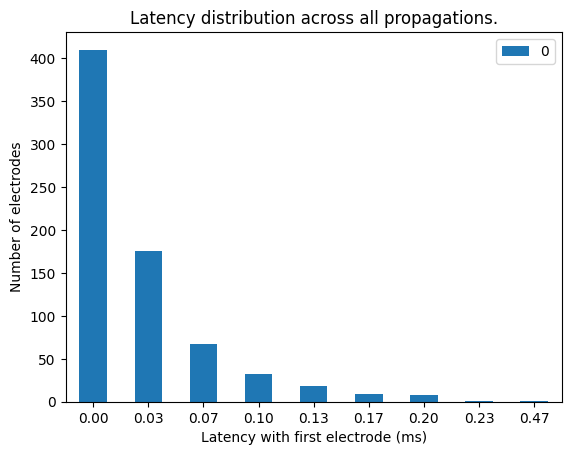

In [13]:
## Plot histogram of inter-electrode latencies
latencies = []
for prop in propagations:
    latencies.extend(prop.latency.values)
latencies, counts = np.unique(latencies, return_counts=True)
from pandas import DataFrame
df = DataFrame(counts, index=[f"{l:.2f}" for l in latencies])
df.plot.bar(rot=0)
plt.title("Latency distribution across all propagations.")
plt.xlabel("Latency with first electrode (ms)")
plt.ylabel("Number of electrodes")
plt.show()

### Get spike times

In [14]:
def get_spike_times(propagations_merged):
    spike_times = np.array(SPIKE_TIMES[:], dtype=object)

    # Sort spike times
    # est_dtype = [('elec', int), ('st', float)]
    # elec_spike_times = []
    # for i, elec in enumerate(spike_times):
    #     elec_spike_times.extend((i, st) for st in elec)
    # elec_spike_times = np.sort(np.array(elec_spike_times, dtype=est_dtype), order="st")

    prop_after = 0.5  # Insignificant change when 1.5 --> 0.5 (mean 8988 to 8787)
    thresh_coactivations = 2
    isi_viol = 1.5

    propagating_times = []
    for prop_m in tqdm(propagations_merged):
        prop_m_times = []
        prop_m_ids = []
        for i, prop in enumerate(prop_m):
            if len(prop) < thresh_coactivations: continue

            ref_spike_times = spike_times[prop.ID[0]]
            tar_spike_times_all = []
            for elec in prop.ID[1:]:
                tar_spike_times = spike_times[elec]
                for ref in ref_spike_times:
                    if np.any((tar_spike_times >= ref) & (tar_spike_times <= ref + prop_after)):
                        tar_spike_times_all.append(ref)

            # zero_latencies = np.sum(prop.latency.values == 0)
            # tar_spike_times_all = []
            # for z in range(zero_latencies):
            #     ref_spike_times = spike_times[prop.ID[z]]
            #     for t in range(len(prop)):
            #         if z == t:
            #             continue
            #         tar_spike_times = spike_times[prop.ID[t]]
            #         for ref in ref_spike_times:
            #             if np.any((tar_spike_times >= ref) & (tar_spike_times <= ref + prop_after)):
            #                 tar_spike_times_all.append(ref)

            prop_spike_times, st_counts = np.unique(tar_spike_times_all, return_counts=True)
            prop_spike_times = prop_spike_times[st_counts >= thresh_coactivations-1] # -1 since just being in the list counts as 2 coactivations
            prop_m_times.extend(prop_spike_times)
            prop_m_ids.extend([i] * len(prop_spike_times))

        if len(prop_m_times) == 0: continue

        ind_sorted = np.argsort(prop_m_times)
        prop_m_times_curated = [prop_m_times[ind_sorted[0]]]
        for i in range(1, len(ind_sorted)):
            i0 = ind_sorted[i-1]
            i1 = ind_sorted[i]
            if prop_m_times[i1] - prop_m_times[i0] > isi_viol:
                prop_m_times_curated.append(prop_m_times[i1])

        # propagating_times.append(np.sort(list(prop_m_times)))
        propagating_times.append(prop_m_times_curated)
        
    return propagating_times

In [15]:
propagating_times = get_spike_times(propagations_merged)

100%|██████████| 84/84 [01:30<00:00,  1.08s/it]


## Save prop signal

In [16]:
prop_signal = PropSignal((propagations_merged, propagating_times), recording)

In [17]:
# prop_signal.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230531")

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Comparison with Kilosort2

Mean: 3608.73
STD: 4322.86


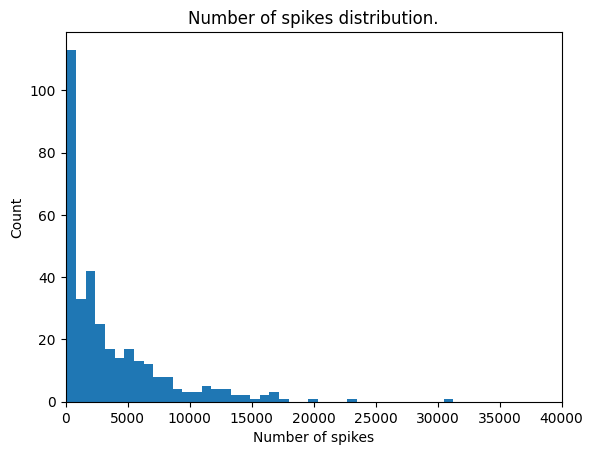

In [18]:
# Load kilosort
kilosort = Kilosort(utils.PATH_SM4_SI, "first", recording)
kilosort.plot_nums_spikes(show=False, bins=40)
plt.xlim(0, 40000)
plt.show()

Getting spike times
Getting match counts and agreement scores


100%|██████████| 84/84 [00:22<00:00,  3.82it/s]

Num Prop.: 84
Num Kilosort2: 339
Num single matches: 65

For Prop.:
Num max matches: 67
Num unique max matches: 47

For Kilosort2:
Num max matches: 142
Num unique max matches: 48


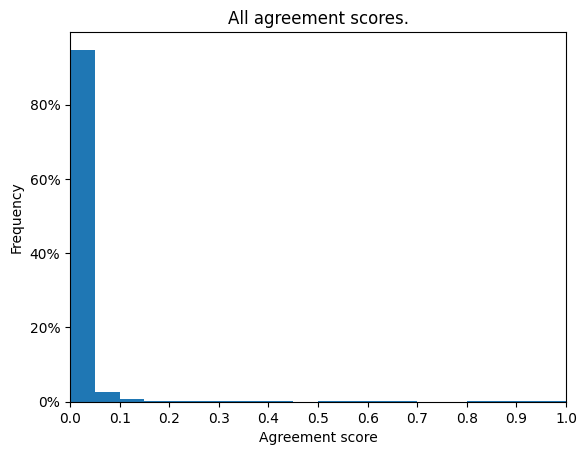

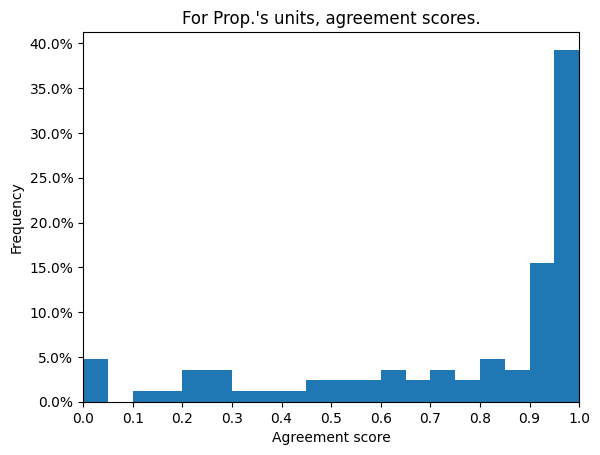

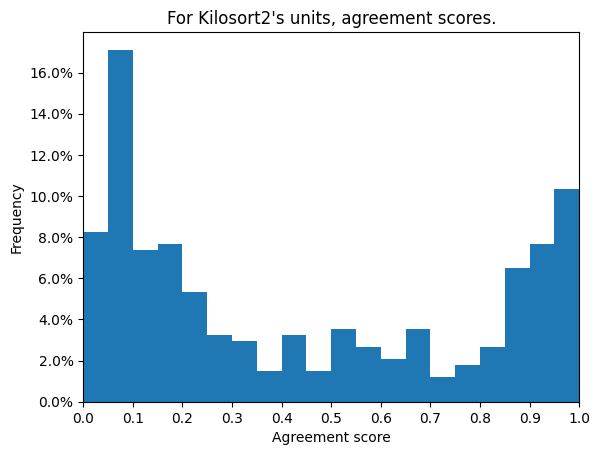

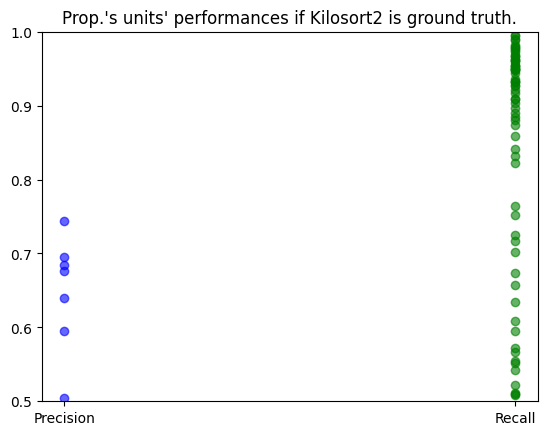

In [19]:
# comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5)
# comp_1 = Comparison(prop_signal, kilosort, score_formula=1)
comp_2 = Comparison(prop_signal, kilosort, score_formula=2)

### Line comparison

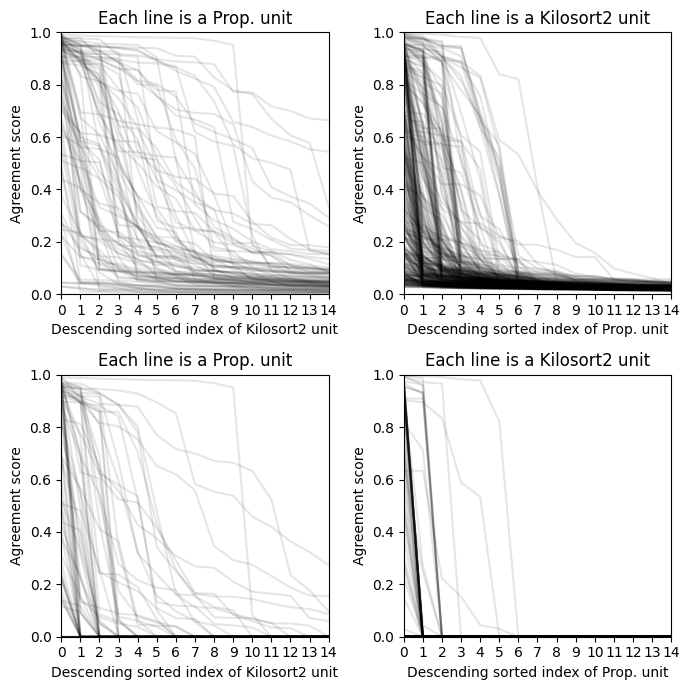

In [20]:
comp_2.plot_line_comps()

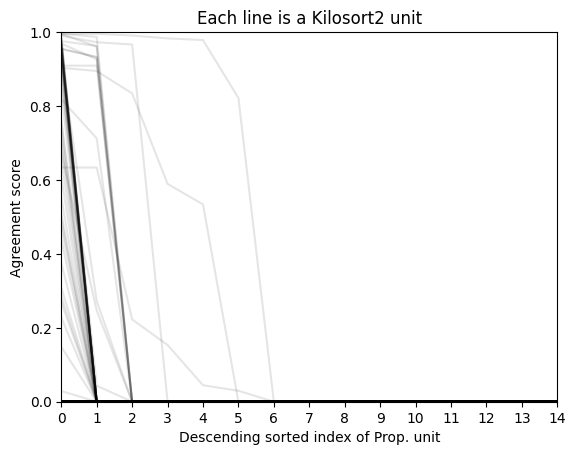

In [21]:
matches = comp_2.plot_line_comp_max(sorter=2)

In [22]:
ks_matches_ind = np.argsort([len(ks) for ks in matches])
ks_idx = ks_matches_ind[-1]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

196 651
6


59 4539
196 651 0.9907834101382489
192 333 0.8318318318318318


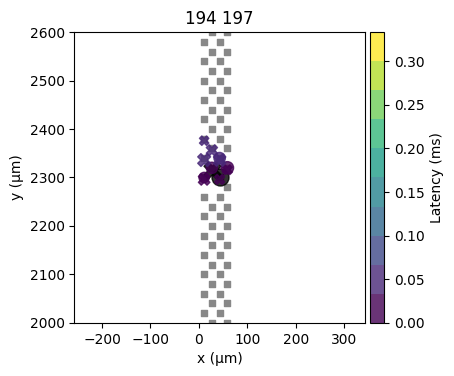

60 2357
196 651 0.9953917050691244
194 69 0.5217391304347826


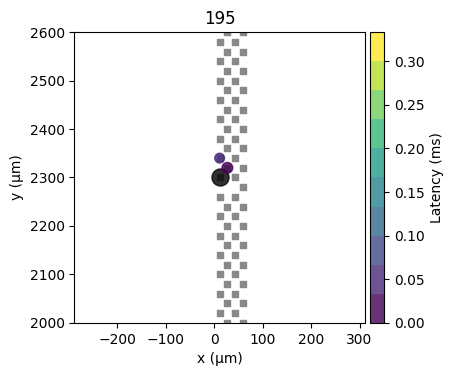

61 3260
196 651 0.9953917050691244
190 346 0.5664739884393064


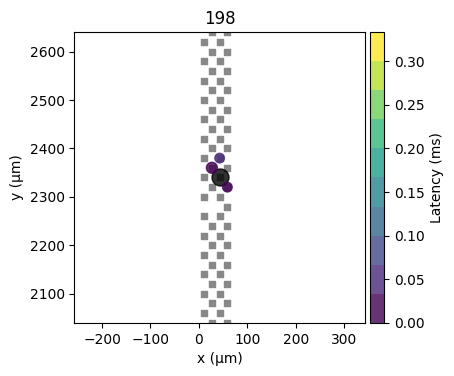

62 5793
196 651 0.978494623655914
197 5612 0.7170349251603706


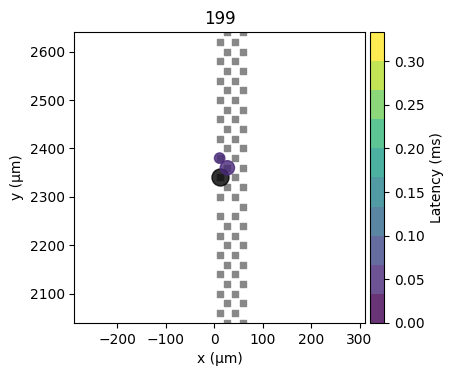

63 2526
196 651 0.8218125960061444
196 651 0.8218125960061444


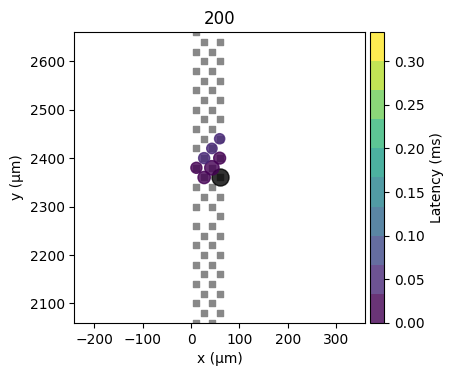

64 5424
196 651 0.9831029185867896
199 899 0.9555061179087876


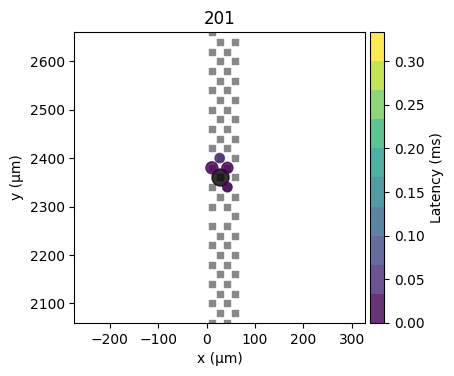

In [23]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

In [24]:
ks_idx = ks_matches_ind[-3]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

206 1948
5


68 7202
206 1948 0.9034907597535934
206 1948 0.9034907597535934


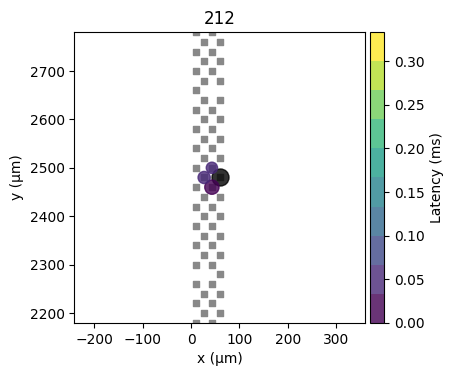

70 7746
206 1948 0.8341889117043121
None


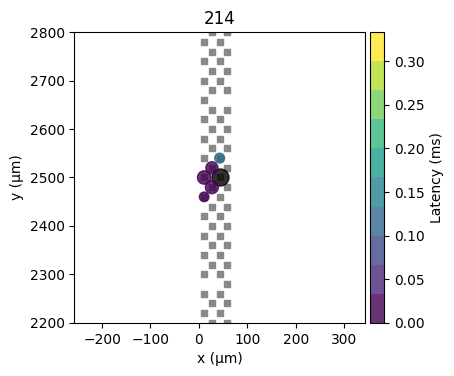

71 2791
206 1948 0.5893223819301848
None


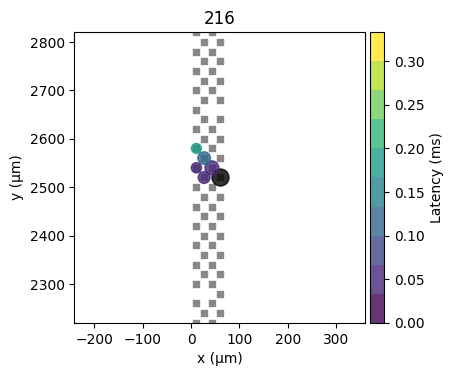

72 9147
206 1948 0.8947638603696099
218 11449 0.5947244300812298


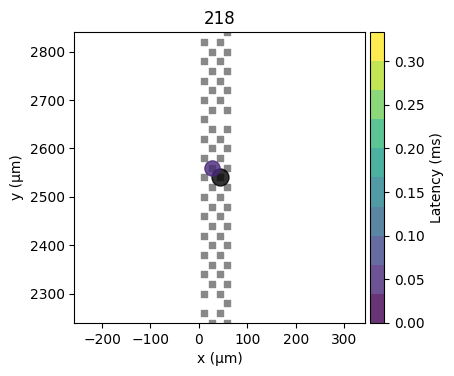

74 3640
206 1948 0.5338809034907598
305 644 0.5108695652173914


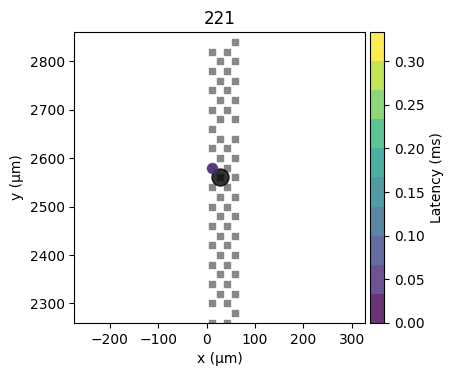

In [25]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

In [26]:
ks_idx = ks_matches_ind[-4]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

123 4155
3


31 16002
123 4155 0.9665463297232251
117 3285 0.8964992389649924


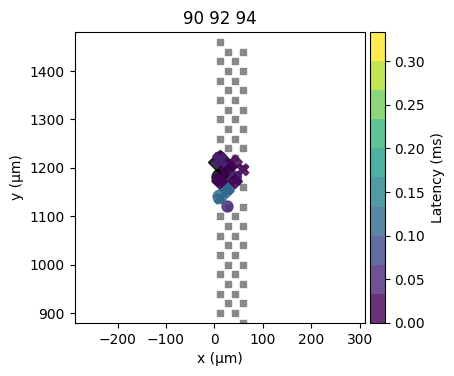

32 12082
123 4155 0.9725631768953069
122 651 0.5422427035330261


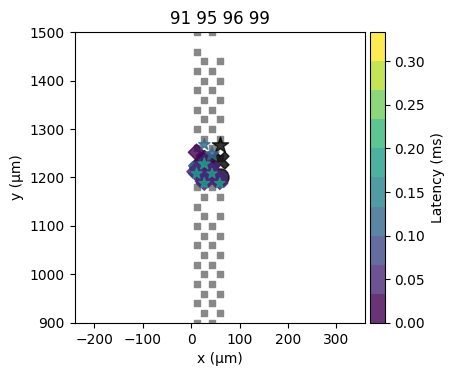

33 6007
123 4155 0.9903730445246691
123 4155 0.9903730445246691


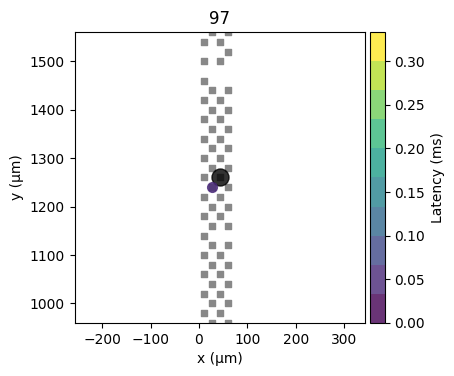

In [27]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

#### Investigation
Figure out why agreement scores are so low

In [387]:
recording = Recording(recording_path, freq_min=300, freq_max=3000)

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


In [490]:
IDX = 0
spike_times_prop = comp_1.spike_times_matching1[IDX]
spike_times_ks = comp_1.spike_times_matching2[IDX]
uid_prop, uid_ks = comp_1.matching_uids[IDX]
unit_ks = kilosort[uid_ks]

In [491]:
prop = propagations_merged[uid_prop]
prop

[   ID  latency  small_window_cooccurrences  n1_n2_ratio
 0   0      0.0                      5500.0     1.000000
 1   1      0.1                      2545.0     0.975844,
    ID   latency  small_window_cooccurrences  n1_n2_ratio
 0   2  0.000000                      7016.0     1.000000
 1   4  0.000000                      3809.0     0.993479
 2   0  0.033333                      4095.0     0.998537
 3   1  0.133333                      4073.0     0.984530]

In [163]:
num_matches, agreement = Comparison.get_match_count_and_agreement_scores([spike_times_prop], [spike_times_ks])
num_matches = num_matches.flatten()[0]
agreement = agreement.flatten()[0]
print(f"Agreement score: {agreement:.3f}")
print(f"Matches/Prop: {num_matches/len(spike_times_prop):.3f}")
print(f"Matches/KS: {num_matches/len(spike_times_ks):.3f}")

NameError: name 'spike_times_prop' is not defined

In [493]:
DELTA_TIME = 0.4
false_negs = []  # Spikes detected by kilosort and not by prop and closest spike times by prop
for st_ks in spike_times_ks:
    i = np.searchsorted(spike_times_prop, st_ks)
    if (i == 0 or st_ks - spike_times_prop[i-1] > DELTA_TIME) and (i == len(spike_times_prop) or spike_times_prop[i] - st_ks > DELTA_TIME):
        print(st_ks)
        print(spike_times_prop[i-1:i+1])
        print()

        st_left = spike_times_prop[i-1] if i > 0 else -1
        st_right = spike_times_prop[i] if i < len(spike_times_prop) else -1
        false_negs.append((st_ks, st_left, st_right))

5839.933333333333
[5467.133333333333, 6334.533333333334]

5864.1
[5467.133333333333, 6334.533333333334]

5872.233333333334
[5467.133333333333, 6334.533333333334]

8218.733333333334
[7887.733333333334, 8252.8]

9534.1
[9213.3, 9543.5]

9556.6
[9543.5, 10632.933333333332]

13321.166666666666
[13316.033333333333, 13476.433333333332]

13670.633333333333
[13476.433333333332, 13950.9]

13690.833333333334
[13476.433333333332, 13950.9]

15519.7
[15507.433333333332, 15636.766666666666]

15601.766666666666
[15507.433333333332, 15636.766666666666]

15616.666666666666
[15507.433333333332, 15636.766666666666]

15738.7
[15733.2, 15979.533333333333]

16196.766666666666
[16182.3, 16620.733333333334]

16398.666666666668
[16182.3, 16620.733333333334]

17345.866666666665
[17329.966666666667, 17889.466666666667]

17734.433333333334
[17329.966666666667, 17889.466666666667]

17763.8
[17329.966666666667, 17889.466666666667]

18305.3
[18188.933333333334, 18589.433333333334]

18622.733333333334
[18589.43333333

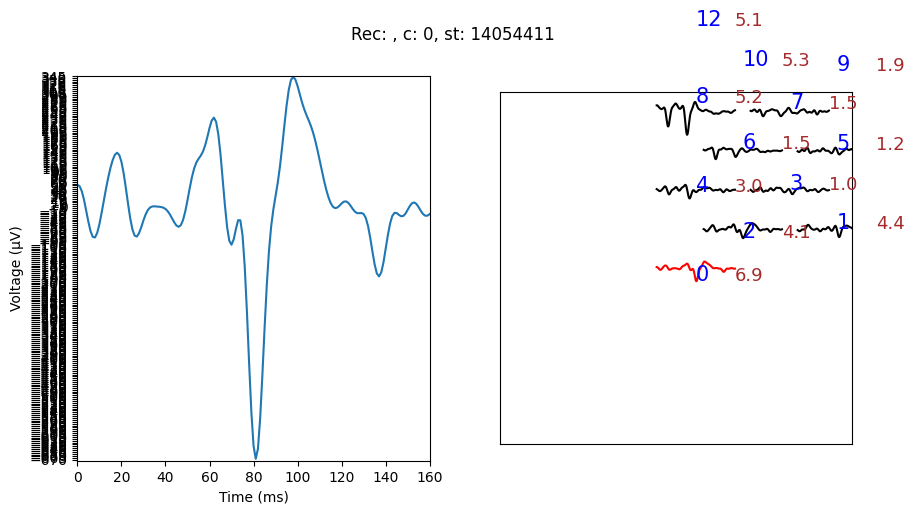

468480.36666666664
468441.5333333333 468607.0333333333
38.83333333331393 126.66666666668607


In [496]:
np.random.seed(5463)
N_BEFORE = 80
N_AFTER = 80
##
st_idx = np.random.choice(len(false_negs))
st, c1, c2 = false_negs[st_idx]

st_s = int(st * recording.get_sampling_frequency())

fig, (a0, a1) = plt.subplots(1, 2, figsize=(10, 5))
recording.plot_waveform(st_s, chan_center=unit_ks.chan,
                        n_before=80, n_after=80, subplots=(fig, (a0, a1)))
plt.show()
print(st)
print(c1, c2)
print(st-c1, c2-st)

In [495]:
propagations_merged[uid_prop]

[   ID  latency  small_window_cooccurrences  n1_n2_ratio
 0   0      0.0                      5500.0     1.000000
 1   1      0.1                      2545.0     0.975844,
    ID   latency  small_window_cooccurrences  n1_n2_ratio
 0   2  0.000000                      7016.0     1.000000
 1   4  0.000000                      3809.0     0.993479
 2   0  0.033333                      4095.0     0.998537
 3   1  0.133333                      4073.0     0.984530]

In [403]:
chan = unit_ks.chan

In [404]:
idx, closest = utils.find_closest(SPIKE_TIMES[chan], st)
print(st)
print(closest - st)
print(SPIKE_TIMES[chan][idx-1:idx+2])

895766.7
-5.599999999976717
[895761.1        895803.86666667 895815.63333333]


In [409]:
from scipy.signal import find_peaks

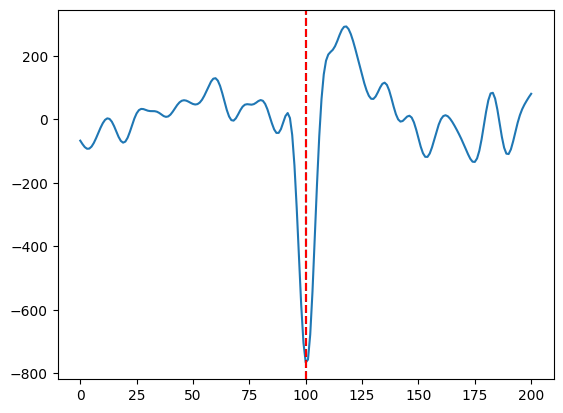

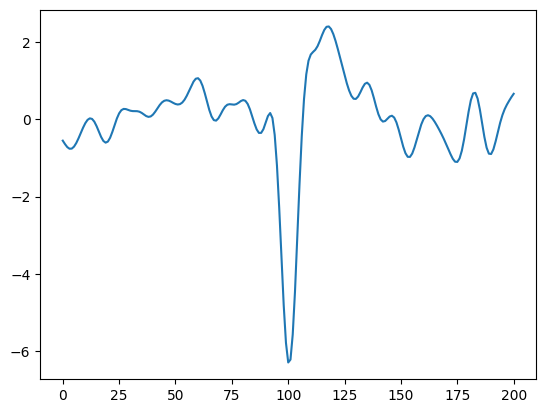

In [415]:
buffer = 100
trace = recording.get_traces_filt(st_s-buffer, st_s+buffer+1, 0).flatten()
noise = np.sqrt(np.mean(recording.get_traces_filt(st_s-500, st_s+500+1, 0).flatten() ** 2))
peaks = find_peaks(-trace, height=5 * noise)[0]

plt.plot(trace)
plt.axvline(buffer, c="black", linestyle="dashed")
for p in peaks:
    plt.axvline(p, c="red", linestyle="dashed")
plt.show()

plt.plot(trace/noise)
plt.show()

In [411]:
peaks

array([], dtype=int64)

In [412]:
trace / (5 * noise)

array([-8.64832401e-02, -1.00581735e-01, -1.12571560e-01, -1.19229130e-01,
       -1.18673988e-01, -1.10576324e-01, -9.59544778e-02, -7.67311826e-02,
       -5.52722700e-02, -3.40746529e-02, -1.56246638e-02, -2.30392022e-03,
        3.82340467e-03,  1.41832302e-03, -9.61920060e-03, -2.77549401e-02,
       -4.97865789e-02, -7.12993294e-02, -8.75539258e-02, -9.45893824e-02,
       -9.02419165e-02, -7.47814626e-02, -5.09380922e-02, -2.32405867e-02,
        3.19307181e-03,  2.40570959e-02,  3.69883440e-02,  4.20351997e-02,
        4.13044952e-02,  3.79261151e-02,  3.47367525e-02,  3.32103334e-02,
        3.30811590e-02,  3.28141935e-02,  3.06830388e-02,  2.59124096e-02,
        1.93055402e-02,  1.30464304e-02,  9.79833491e-03,  1.15680275e-02,
        1.88831054e-02,  3.06216273e-02,  4.44857813e-02,  5.78240417e-02,
        6.84164762e-02,  7.49529749e-02,  7.71456137e-02,  7.55813420e-02,
        7.14657530e-02,  6.63610548e-02,  6.19559959e-02,  5.98694980e-02,
        6.14787564e-02,  

#### Investigation
Look at which propagations overlap with and without merging

In [ ]:
prop_signal = PropSignal()
comp = Comparison()